In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment2/'
FOLDERNAME = 'cs231n/assignments/assignment4/challenges-in-representation-learning-facial-expression-recognition-challenge'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

%cd /content/drive/My\ Drive/$FOLDERNAME/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/cs231n/assignments/assignment4/challenges-in-representation-learning-facial-expression-recognition-challenge


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

!pip install wandb -q
import wandb
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

train_df = pd.read_csv('train.csv')
print(f"Training data shape: {train_df.shape}")
print(f"Columns: {train_df.columns.tolist()}")
print(f"Emotion distribution:")
print(train_df['emotion'].value_counts().sort_index())

Training data shape: (28709, 2)
Columns: ['emotion', 'pixels']
Emotion distribution:
emotion
0    3995
1     436
2    4097
3    7215
4    4830
5    3171
6    4965
Name: count, dtype: int64


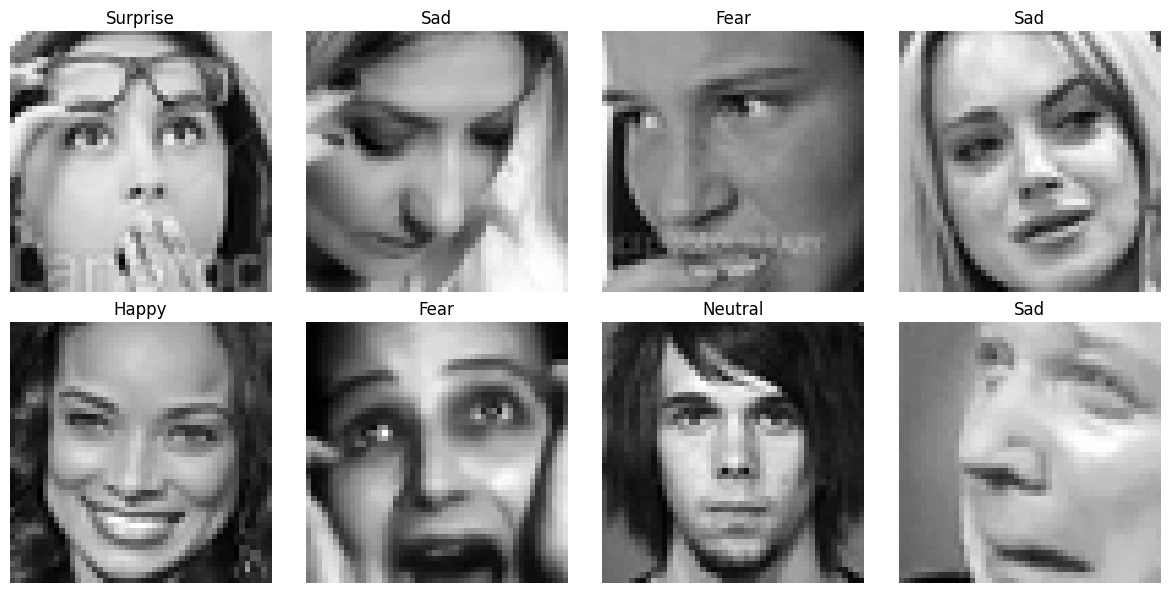

In [4]:
def show_sample_images(df, n_samples=8):
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes = axes.ravel()

    emotion_labels = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy',
                     4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

    for i in range(n_samples):
        idx = np.random.randint(0, len(df))
        pixels = np.array([int(pixel) for pixel in df.iloc[idx]['pixels'].split()]).reshape(48, 48)
        emotion = df.iloc[idx]['emotion']

        axes[i].imshow(pixels, cmap='gray')
        axes[i].set_title(f'{emotion_labels[emotion]}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

show_sample_images(train_df)

In [5]:
from google.colab import userdata
wandb_api_key = userdata.get('wandb_api')
assert wandb_api_key is not None, "wandb_api_key not found in secrets!"

wandb.login(key=wandb_api_key)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: gmode (gmode-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [6]:
class FERDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        pixels = np.array([int(p) for p in self.data.iloc[idx]['pixels'].split()], dtype=np.uint8).reshape(48, 48)
        image = transforms.ToPILImage()(pixels[:, :, None])  # Add channel dimension
        label = int(self.data.iloc[idx]['emotion'])

        if self.transform:
            image = self.transform(image)

        return image, label


In [7]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data, val_data = train_test_split(train_df, test_size=0.1, stratify=train_df['emotion'], random_state=42)

train_dataset = FERDataset(train_data, transform=transform)
val_dataset = FERDataset(val_data, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


In [8]:
class ImprovedCNNv1(nn.Module):
    def __init__(self):
        super(ImprovedCNNv1, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),  # 48x48
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 24x24

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 12x12

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 6x6

            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 3x3

            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(256 * 3 * 3, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 7)
        )

    def forward(self, x):
        return self.net(x)


In [10]:
wandb.init(project="fer-challenge", name="improved-cnn-v1")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ImprovedCNNv1().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

for epoch in range(10):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * labels.size(0)
            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= val_total
    val_acc = val_correct / val_total

    # Log to wandb
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": train_loss,
        "train_accuracy": train_acc,
        "val_loss": val_loss,
        "val_accuracy": val_acc
    })

    print(f"Epoch {epoch+1}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")


100%|██████████| 404/404 [04:09<00:00,  1.62it/s]


Epoch 1: Train Acc=0.3631, Val Acc=0.4545


100%|██████████| 404/404 [04:08<00:00,  1.63it/s]


Epoch 2: Train Acc=0.4778, Val Acc=0.5023


100%|██████████| 404/404 [04:23<00:00,  1.53it/s]


Epoch 3: Train Acc=0.5195, Val Acc=0.5367


100%|██████████| 404/404 [04:15<00:00,  1.58it/s]


Epoch 4: Train Acc=0.5471, Val Acc=0.5298


100%|██████████| 404/404 [04:16<00:00,  1.58it/s]


Epoch 5: Train Acc=0.5730, Val Acc=0.5681


100%|██████████| 404/404 [04:16<00:00,  1.57it/s]


Epoch 6: Train Acc=0.5886, Val Acc=0.5824


100%|██████████| 404/404 [04:18<00:00,  1.56it/s]


Epoch 7: Train Acc=0.6105, Val Acc=0.5904


100%|██████████| 404/404 [04:16<00:00,  1.57it/s]


Epoch 8: Train Acc=0.6316, Val Acc=0.6116


100%|██████████| 404/404 [04:15<00:00,  1.58it/s]


Epoch 9: Train Acc=0.6497, Val Acc=0.6075


100%|██████████| 404/404 [04:14<00:00,  1.59it/s]


Epoch 10: Train Acc=0.6750, Val Acc=0.6158
